In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [6]:
df = pd.read_csv('quntity_sum_sorted_by_date_complete.csv')

In [7]:
unique_dates = df[[
    'transaction_date']].drop_duplicates().values
# Split the dates into 80:20 train and test sets
train_dates, test_dates = train_test_split(
    unique_dates, test_size=0.2, shuffle=False)

In [22]:
train_dates

array([['2024-01-01'],
       ['2024-01-02'],
       ['2024-01-03'],
       ['2024-01-04'],
       ['2024-01-05'],
       ['2024-01-06'],
       ['2024-01-07'],
       ['2024-01-08'],
       ['2024-01-09'],
       ['2024-01-10'],
       ['2024-01-11'],
       ['2024-01-12'],
       ['2024-01-13'],
       ['2024-01-14'],
       ['2024-01-15'],
       ['2024-01-16'],
       ['2024-01-17'],
       ['2024-01-18'],
       ['2024-01-19'],
       ['2024-01-20'],
       ['2024-01-21'],
       ['2024-01-22'],
       ['2024-01-23'],
       ['2024-01-24'],
       ['2024-01-25'],
       ['2024-01-26'],
       ['2024-01-27'],
       ['2024-01-28'],
       ['2024-01-29'],
       ['2024-01-30'],
       ['2024-01-31'],
       ['2024-02-01'],
       ['2024-02-02'],
       ['2024-02-03'],
       ['2024-02-04'],
       ['2024-02-05'],
       ['2024-02-06'],
       ['2024-02-07'],
       ['2024-02-08'],
       ['2024-02-09'],
       ['2024-02-10'],
       ['2024-02-11'],
       ['2024-02-12'],
       ['20

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [9]:
class SalesDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.unique_dates = df['transaction_date'].unique()
        self.num_records_per_day = len(
            df[df['transaction_date'] == self.unique_dates[0]])

    def __len__(self):
        return len(self.unique_dates) - 1

    def __getitem__(self, idx):
        current_date = self.unique_dates[idx]
        next_date = self.unique_dates[idx + 1]

        current_data = self.df[self.df['transaction_date'] == current_date]
        next_data = self.df[self.df['transaction_date'] == next_date]

        data = current_data[['store_id', 'product_id',
                             'transaction_qty', 'day_of_week']].values
        target = next_data['transaction_qty'].values

        return torch.tensor(data, dtype=torch.float), torch.tensor(target, dtype=torch.float)

In [10]:
# Create the dataset and dataloader
dataset = SalesDataset(df)
dataloader = DataLoader(dataset, batch_size=7, shuffle=True)

In [11]:
# # Define the LSTM model
# class LSTM(nn.Module):
#     def __init__(self, input_size=4, hidden_layer_size=50, output_size=1):
#         super().__init__()
#         self.hidden_layer_size = hidden_layer_size
#         self.lstm = nn.LSTM(input_size, hidden_layer_size)
#         self.linear = nn.Linear(hidden_layer_size, output_size)
#         self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
#                             torch.zeros(1, 1, self.hidden_layer_size))

#     def forward(self, input_seq):
#         lstm_out, self.hidden_cell = self.lstm(
#             input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
#         predictions = self.linear(lstm_out.view(len(input_seq), -1))
#         return predictions

In [76]:
class LSTM(nn.Module):
    def __init__(self, input_size=4, hidden_layer_size=64, output_size=1, num_layers=4, dropout=0.5):
        super(LSTM, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_layer_size,
                            num_layers=num_layers, dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        h0 = torch.zeros(self.num_layers, input_seq.size(
            0), self.hidden_layer_size).to(input_seq.device)
        c0 = torch.zeros(self.num_layers, input_seq.size(
            0), self.hidden_layer_size).to(input_seq.device)

        lstm_out, _ = self.lstm(input_seq, (h0, c0))
        lstm_out = self.dropout(lstm_out)
        predictions = self.linear(lstm_out[:, :, :])
        return predictions

In [77]:
# class LSTM(nn.Module):
#     def __init__(self, input_size=4, hidden_layer_size=50, output_size=1, num_layers=2, dropout=0.5):
#         super().__init__()
#         self.hidden_layer_size = hidden_layer_size
#         self.num_layers = num_layers

#         self.lstm = nn.LSTM(input_size, hidden_layer_size,
#                             num_layers=num_layers, dropout=dropout, batch_first=True)
#         self.dropout = nn.Dropout(dropout)
#         self.linear = nn.Linear(hidden_layer_size, output_size)
#         self.hidden_cell = None

#     def forward(self, input_seq):
#         # If this is the first batch, initialize the hidden state with zeros
#         if self.hidden_cell is None:
#             self.hidden_cell = (torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device),
#                                 torch.zeros(self.num_layers, input_seq.size(0), self.hidden_layer_size).to(input_seq.device))

#         lstm_out, self.hidden_cell = self.lstm(
#             input_seq.view(len(input_seq), 1, -1), self.hidden_cell)
#         lstm_out = self.dropout(lstm_out)
#         predictions = self.linear(lstm_out.view(len(input_seq), -1))
#         return predictions

In [78]:
def train_model(model, criterion, optimizer, train_dates, df, unique_dates):
    model.train()
    train_losses = []  
    for date in train_dates:
        # Prepare the data
        # print("date", date[0])
        # print(df[(df['transaction_date'] == date[0])])

        records = df[(df['transaction_date'] == date[0])
                     ][['transaction_qty', 'day_of_week', 'store_id', 'product_id']]
        data = torch.tensor(records.values.reshape(
            (1, -1, 4)), dtype=torch.float)

        next_day_index = np.where(unique_dates == date)[0][0] + 1
        # print(np.where(unique_dates == date)[0][0])
        # print("next_day_index", next_day_index)
        if next_day_index < len(unique_dates):
            next_day_date = unique_dates[next_day_index][0]
            # print(df[(df['transaction_date'] == next_day_date)])
            # print("next_day_date", next_day_date)
            next_day_records = df[(df['transaction_date'] == next_day_date)
                                  ][['transaction_qty', 'day_of_week', 'store_id', 'product_id']]
            # print(next_day_records.shape)
            target = torch.tensor(
                next_day_records['transaction_qty'].values, dtype=torch.float).view(1, -1, 1)
            # Zero out the gradients
            optimizer.zero_grad()

            # # Forward pass
            # model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
            #                      torch.zeros(1, 1, model.hidden_layer_size))
            predictions = model(data)
            # break
            # Calculate the loss
            loss = criterion(predictions, target)
            train_losses.append(loss.item())

            # Backward pass and optimize
            loss.backward()
            optimizer.step()
        # if date == train_dates[0]:
        #     print("data", data.shape)
        #     print("records", records.shape)
        #     print("target shape", target.shape)
        #     print("predictions", predictions.shape)
        # break
    return np.mean(train_losses), model

In [79]:
def evaluate_model(model, criterion, test_dates, df, unique_dates):
    model.eval()
    test_losses = []
    with torch.no_grad():
        for date in test_dates:
            # Prepare the data
            records = df[(df['transaction_date'] == date[0])
                         ][['transaction_qty', 'day_of_week', 'store_id', 'product_id']]
            # print(df[(df['transaction_date'] == date[0])])
            data = torch.tensor(records.values.reshape(1, -1, 4), dtype=torch.float)
            next_day_index = np.where(unique_dates == date)[0][0] + 1
            if next_day_index < len(unique_dates):
                next_day_date = unique_dates[next_day_index][0]
                # print(df[(df['transaction_date'] == next_day_date)])
                next_day_records = df[(df['transaction_date'] == next_day_date)
                                      ][['transaction_qty', 'day_of_week', 'store_id', 'product_id']]
                # In the train_model function
                target = torch.tensor(next_day_records['transaction_qty'].values, dtype=torch.float).view(1, -1, 1)

                # Forward pass
                model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                                     torch.zeros(1, 1, model.hidden_layer_size))
                predictions = model(data)

                # # Calculate the loss
                loss = criterion(predictions, target)
                # loss.backward()
                test_losses.append(loss.item())
            # if date == train_dates[0]:
            #     print("data", data.shape)
            #     print("records", records.shape)
            #     print("target shape", target.shape)
            #     print("predictions", predictions.shape)
    return np.mean(test_losses)

In [80]:
# Initialize the model, loss function and optimizer
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def model_fit(model, criterion, optimizer, train_dates, test_dates, df, unique_dates, num_epochs=25):
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}")
        train_loss, model = train_model(
            model, criterion, optimizer, train_dates, df, unique_dates)
        test_loss = evaluate_model(
            model, criterion, test_dates, df, unique_dates)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    return model, train_losses, test_losses

In [81]:
model,train_losses, test_losses = model_fit(model=model, criterion=loss_function, optimizer=optimizer, train_dates=train_dates, test_dates=test_dates, df=df, unique_dates=unique_dates, num_epochs=10)


Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


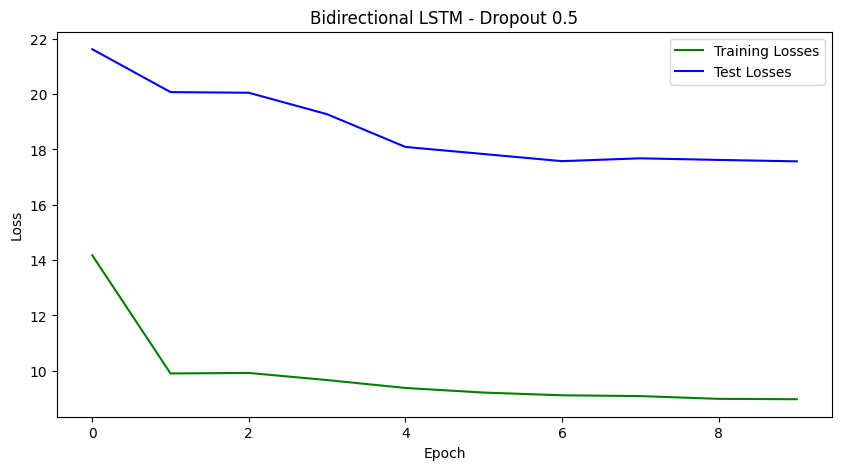

In [82]:
plt.figure(figsize=(10, 5))
train_epochs = range(len(train_losses))
test_epochs = np.linspace(0, len(train_losses)-1, num=len(test_losses))

plt.plot(train_epochs, train_losses, 'g-', label='Training Losses')
plt.plot(test_epochs, test_losses, 'b-', label='Test Losses')
plt.title('Bidirectional LSTM - Dropout 0.5')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
input_size = 87 * 3 * 4
model = LSTM(input_size=input_size)

In [ ]:
# Training loop
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train_model(model, criterion, optimizer, dataloader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        train_losses = []
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            train_losses.append(loss.item())
            loss.backward()
            optimizer.step()
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {np.mean(train_losses)}')


# Train the model
train_model(model, criterion, optimizer, dataloader)

RuntimeError: input.size(-1) must be equal to input_size. Expected 1044, got 4